# Trabajo Práctico para condición de Libre: Predicción de lluvia en Australia.

## Librerias

In [1]:
%%capture
!pip install seaborn
!pip install optuna
!pip instal keras-tuner
!pip install tensorflow

## Carga y modificación del dataset


In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv(r'weatherAUS.csv')


In [3]:
# Seleccion de ciudades relevantes

ciudades = ['Albury', 'Sydney', 'SydneyAirport', 'Canberra', 'Melbourne', 'MelbourneAirport']
df = df[df['Location'].isin(ciudades)]

# Verificar los primeros registros
df.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0
1,1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0
2,2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0
4,4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.2


In [4]:
# Elimino location ya que tomo todas las ubicaciones como si fueran una misma.
# Unnamed: 0: tambien elimino esta columna, ya que no aporta nada de información al modelo.
df = df.drop(['Unnamed: 0', 'Location'], axis=1)

df

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,2008-12-01,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0
1,2008-12-02,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0
2,2008-12-03,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,2008-12-04,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0
4,2008-12-05,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70366,2017-06-20,6.4,15.8,0.0,2.4,8.8,N,39.0,NNE,N,...,56.0,1028.1,1024.5,1.0,7.0,7.9,15.6,No,No,0.6
70367,2017-06-21,7.8,13.5,0.6,0.6,0.0,NNW,24.0,W,S,...,80.0,1028.8,1028.4,7.0,7.0,11.2,12.7,No,No,0.2
70368,2017-06-22,6.7,14.1,0.2,0.6,0.0,N,24.0,NNE,N,...,56.0,1028.2,1024.8,7.0,7.0,7.5,13.5,No,No,0.0
70369,2017-06-23,7.4,14.9,0.0,1.6,6.0,NNW,44.0,N,N,...,63.0,1018.8,1013.8,1.0,7.0,9.1,12.5,No,Yes,1.4


In [5]:
#vemos los valores nulos de la variable a predecir
nulos_raintomorrow = df["RainTomorrow"].isnull().sum()

print("El Dataset cuenta con " +  str(nulos_raintomorrow) + " Valores nulos en la variable a predecir.")

#Eliminamos del Dataset las filas que en la columna RainTomorrow sean nulas, ya que no nos sirve para el modelo.
df = df.dropna(subset=["RainTomorrow"])

El Dataset cuenta con 816 Valores nulos en la variable a predecir.


In [6]:
#vemos los valores nulos de la variable a predecir
nulos_raintomorrow = df["RainfallTomorrow"].isnull().sum()

print("El Dataset cuenta con " +  str(nulos_raintomorrow) + " Valores nulos en la variable a predecir.")



El Dataset cuenta con 0 Valores nulos en la variable a predecir.


## División de datos: Train y Test
Separo el dataset antes de imputar nulos para evitar data leakage. La división por fecha mantiene la integridad temporal, crucial en series temporales y problemas dependientes del tiempo. Usar una división aleatoria podría filtrar datos de prueba en el entrenamiento, causando sobreajuste y menor generalización.

In [7]:
df["Date"] = pd.to_datetime(df["Date"])

C:\Users\brisa\AppData\Local\Temp\ipykernel_7492\936118274.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"] = pd.to_datetime(df["Date"])


In [8]:
# Mostrar la primera y última fecha
primera_fecha = df['Date'].min()
ultima_fecha = df['Date'].max()

print("Primera fecha:", primera_fecha)
print("Última fecha:", ultima_fecha)

Primera fecha: 2007-11-01 00:00:00
Última fecha: 2017-06-24 00:00:00


In [9]:
# Calcular la fecha que abarque el 80% de los datos
fecha_80porciento = df['Date'].quantile(0.80)

print("Fecha que abarca el 80% de los datos:", fecha_80porciento)


Fecha que abarca el 80% de los datos: 2015-09-17 00:00:00


In [10]:
# Dividir los datos en conjuntos de entrenamiento y prueba basados en la fecha
train = df[df['Date'] <= fecha_80porciento]
test = df[df['Date'] > fecha_80porciento]

print("Tamaño del conjunto de entrenamiento:", train.shape)
print("Tamaño del conjunto de prueba:", test.shape)

Tamaño del conjunto de entrenamiento: (14570, 23)
Tamaño del conjunto de prueba: (3639, 23)


La fecha puede ayudar a predecir la lluvia porque sigue patrones según la época del año. En vez de quitarla, la convertimos en números (días desde una fecha base) para que el modelo entienda mejor estos cambios con el tiempo.

In [11]:
#Convierto la columna de fecha en un número de días desde una fecha base:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

C:\Users\brisa\AppData\Local\Temp\ipykernel_7492\1750518221.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Date'] = pd.to_datetime(train['Date'])
C:\Users\brisa\AppData\Local\Temp\ipykernel_7492\1750518221.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Date'] = pd.to_datetime(test['Date'])


In [12]:
# Extraer el número de días desde una fecha base
base_date = pd.to_datetime('2000-01-01')
train['Date'] = (train['Date'] - base_date).dt.days
test['Date'] = (test['Date'] - base_date).dt.days

C:\Users\brisa\AppData\Local\Temp\ipykernel_7492\2609680140.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Date'] = (train['Date'] - base_date).dt.days
C:\Users\brisa\AppData\Local\Temp\ipykernel_7492\2609680140.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Date'] = (test['Date'] - base_date).dt.days


## Visualización y Exploración de Datos (Train)


In [13]:
# Mostrar las primeras filas y nombres de las columnas
train.head()
train.columns


Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')

In [14]:
#Analizamos los tipos de datos de cada columna
train.dtypes


Date                  int64
MinTemp             float64
MaxTemp             float64
Rainfall            float64
Evaporation         float64
Sunshine            float64
WindGustDir          object
WindGustSpeed       float64
WindDir9am           object
WindDir3pm           object
WindSpeed9am        float64
WindSpeed3pm        float64
Humidity9am         float64
Humidity3pm         float64
Pressure9am         float64
Pressure3pm         float64
Cloud9am            float64
Cloud3pm            float64
Temp9am             float64
Temp3pm             float64
RainToday            object
RainTomorrow         object
RainfallTomorrow    float64
dtype: object

In [15]:
#Verificamos la presencia de valores nulos
train.isna().sum()


Date                   0
MinTemp               14
MaxTemp                6
Rainfall             172
Evaporation         3390
Sunshine            3651
WindGustDir         1417
WindGustSpeed       1415
WindDir9am          1023
WindDir3pm           311
WindSpeed9am         262
WindSpeed3pm         254
Humidity9am           89
Humidity3pm           46
Pressure9am          250
Pressure3pm          246
Cloud9am            3074
Cloud3pm            3253
Temp9am               26
Temp3pm               18
RainToday            172
RainTomorrow           0
RainfallTomorrow       0
dtype: int64

In [16]:
#Para una visión general de las estadísticas descriptivas
train.describe(include='all')


,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
count,14570.000000,14556.00000,14564.000000,14398.000000,11180.000000,10919.000000,13153,13155.000000,13547,14259,...,14524.000000,14320.000000,14324.000000,11496.00000,11317.000000,14544.000000,14552.000000,14398,14570,14570.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,16,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,N,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,No,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,1737,NaN,1947,1640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11123,11233,NaN
mean,4393.605697,11.03852,21.646512,2.207751,4.756369,6.884559,NaN,42.576967,NaN,NaN,...,50.690788,1018.415237,1016.101780,4.84064,4.797738,15.105494,20.194667,NaN,NaN,2.206699
std,769.169604,5.97530,6.295846,7.197195,3.008018,3.833424,NaN,15.513806,NaN,NaN,...,18.037733,7.349364,7.208299,2.75280,2.619806,5.710035,6.106008,NaN,NaN,7.170383
min,2861.000000,-8.00000,4.100000,0.000000,0.000000,0.000000,NaN,9.000000,NaN,NaN,...,3.000000,986.700000,982.900000,0.00000,0.000000,-1.300000,3.700000,NaN,NaN,0.000000
25%,3733.000000,7.20000,16.800000,0.000000,2.550000,3.800000,NaN,31.000000,NaN,NaN,...,38.000000,1013.500000,1011.200000,2.00000,2.000000,11.000000,15.600000,NaN,NaN,0.000000
50%,4382.000000,11.10000,21.100000,0.000000,4.000000,7.600000,NaN,41.000000,NaN,NaN,...,50.000000,1018.500000,1016.200000,6.00000,6.000000,15.000000,19.600000,NaN,NaN,0.000000
75%,5073.000000,15.40000,25.800000,0.800000,6.600000,10.000000,NaN,52.000000,NaN,NaN,...,62.000000,1023.400000,1021.000000,7.00000,7.000000,19.200000,24.200000,NaN,NaN,0.800000


In [17]:
#informacion general
train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 14570 entries, 0 to 69469
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              14570 non-null  int64  
 1   MinTemp           14556 non-null  float64
 2   MaxTemp           14564 non-null  float64
 3   Rainfall          14398 non-null  float64
 4   Evaporation       11180 non-null  float64
 5   Sunshine          10919 non-null  float64
 6   WindGustDir       13153 non-null  object 
 7   WindGustSpeed     13155 non-null  float64
 8   WindDir9am        13547 non-null  object 
 9   WindDir3pm        14259 non-null  object 
 10  WindSpeed9am      14308 non-null  float64
 11  WindSpeed3pm      14316 non-null  float64
 12  Humidity9am       14481 non-null  float64
 13  Humidity3pm       14524 non-null  float64
 14  Pressure9am       14320 non-null  float64
 15  Pressure3pm       14324 non-null  float64
 16  Cloud9am          11496 non-null  float64
 17

In [18]:
# Contamos el número total de filas completamente nulas
nulas = train.isnull().all(axis=1).sum()
print("Filas completamente nulas:", nulas)


Filas completamente nulas: 0


In [19]:
# Número total de valores no nulos en cada columna
train.count()


Date                14570
MinTemp             14556
MaxTemp             14564
Rainfall            14398
Evaporation         11180
Sunshine            10919
WindGustDir         13153
WindGustSpeed       13155
WindDir9am          13547
WindDir3pm          14259
WindSpeed9am        14308
WindSpeed3pm        14316
Humidity9am         14481
Humidity3pm         14524
Pressure9am         14320
Pressure3pm         14324
Cloud9am            11496
Cloud3pm            11317
Temp9am             14544
Temp3pm             14552
RainToday           14398
RainTomorrow        14570
RainfallTomorrow    14570
dtype: int64

## Graficos de Train

In [20]:
!python -m ensurepip --upgrade
!python get-pip.py



Looking in links: c:\Users\brisa\AppData\Local\Temp\tmpcc1o6k1h


C:\Users\brisa\AppData\Local\Programs\Python\Python311\python.exe: can't open file 'c:\\Users\\brisa\\OneDrive\\Desktop\\Tp-libre-AA1\\get-pip.py': [Errno 2] No such file or directory


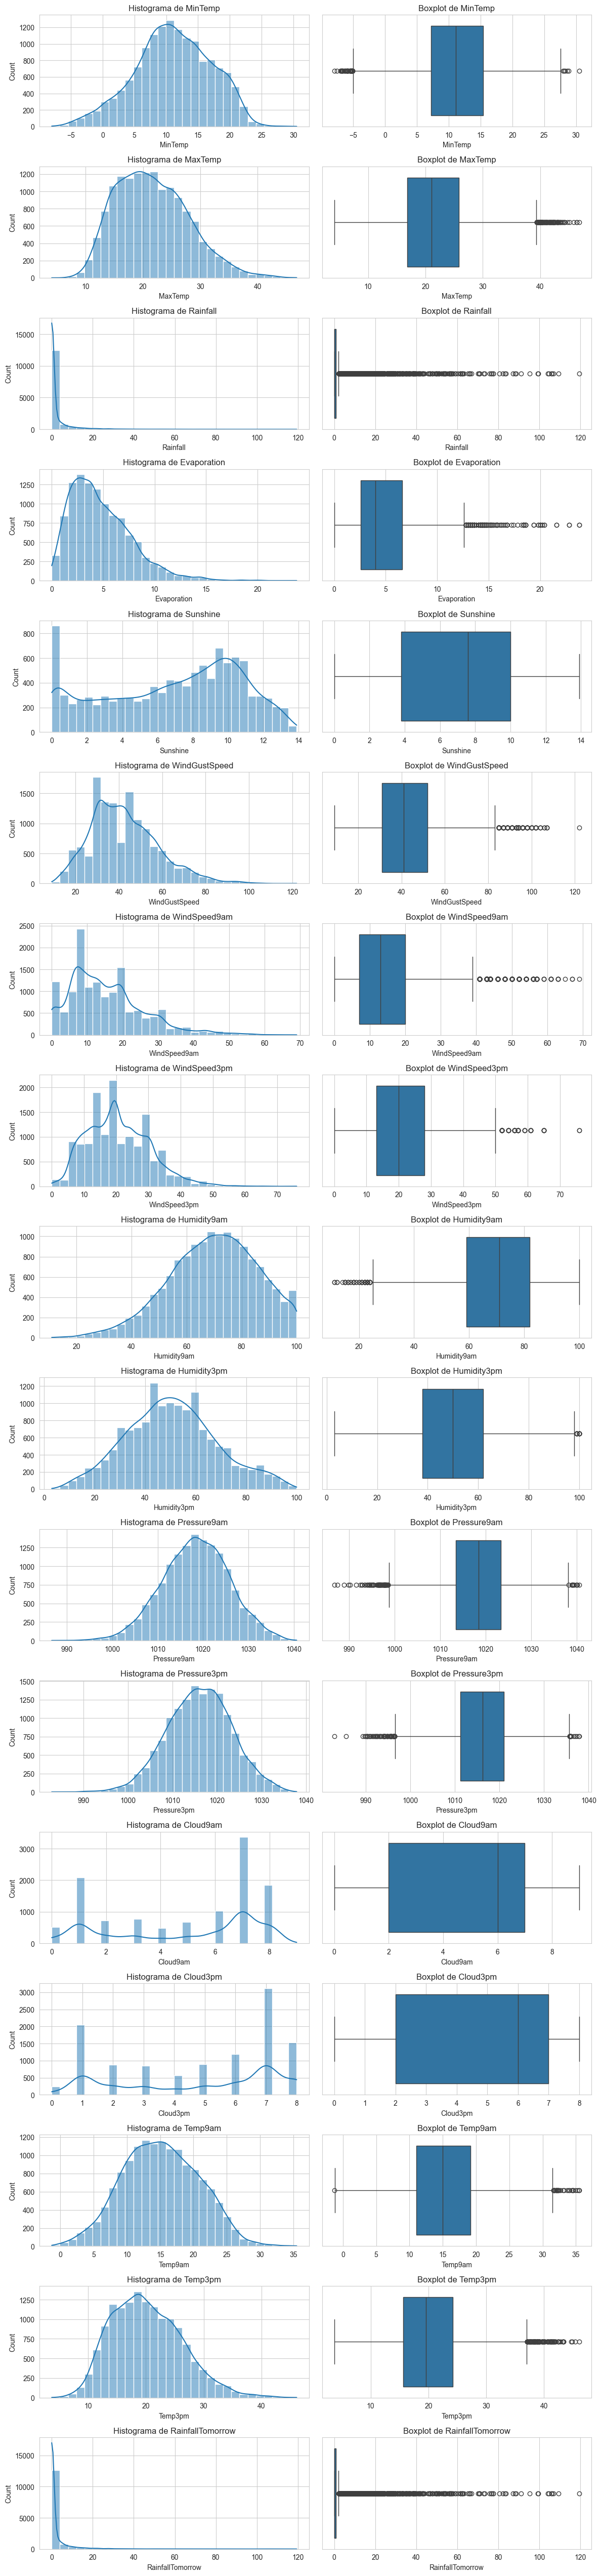

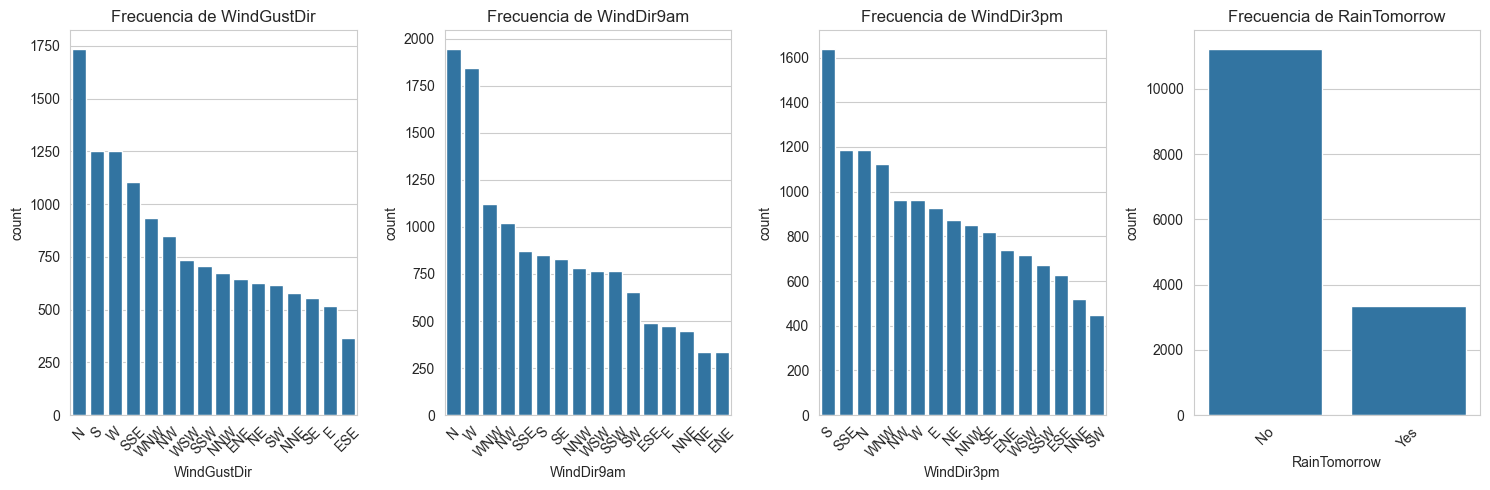

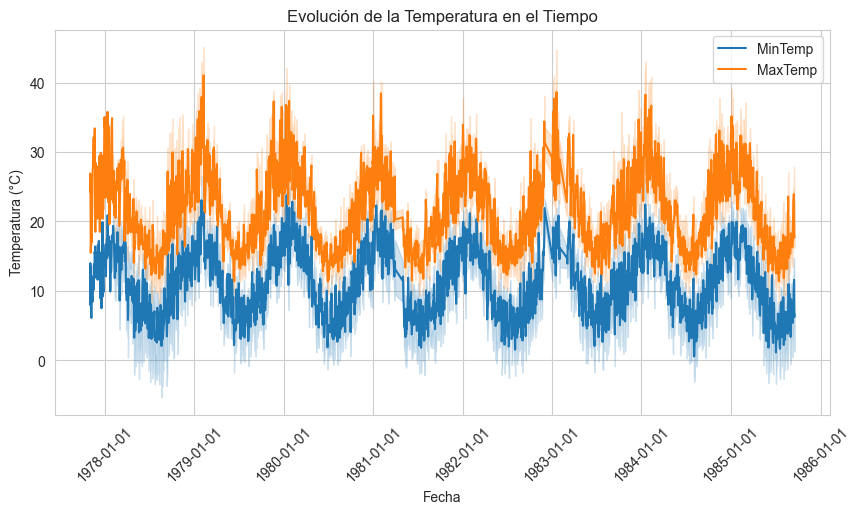

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates


# Configuración general de los gráficos
sns.set_style("whitegrid")

# Variables numéricas a analizar
numerical_features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                      'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
                      'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
                      'Temp9am', 'Temp3pm', 'RainfallTomorrow']

# Histograma y boxplot para variables numéricas
fig, axes = plt.subplots(len(numerical_features), 2, figsize=(12, len(numerical_features) * 3))

for i, feature in enumerate(numerical_features):
    sns.histplot(train[feature].dropna(), bins=30, kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histograma de {feature}')

    sns.boxplot(x=train[feature], ax=axes[i, 1])
    axes[i, 1].set_title(f'Boxplot de {feature}')

plt.tight_layout()
plt.show()

# Análisis de variables categóricas
categorical_features = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainTomorrow']
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i, feature in enumerate(categorical_features):
    sns.countplot(x=train[feature], order=train[feature].value_counts().index, ax=axes[i])
    axes[i].set_title(f'Frecuencia de {feature}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# Serie temporal de temperaturas
plt.figure(figsize=(10, 5))
sns.lineplot(x='Date', y='MinTemp', data=train, label='MinTemp')
sns.lineplot(x='Date', y='MaxTemp', data=train, label='MaxTemp')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.title('Evolución de la Temperatura en el Tiempo')
plt.legend()

# Mejorar la visualización del eje X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)

plt.show()


### **Distribuciones Bimodales** (dos picos claros en el histograma)
1. **WindSpeed9am**  
2. **WindSpeed3pm**  
3. **Cloud9am**  
4. **Cloud3pm**  

Estas variables presentan dos acumulaciones de datos en diferentes valores, lo que sugiere una distribución bimodal.

### **Distribuciones No Bimodales** (distribuciones unimodales o asimétricas)
1. **MinTemp** - Unimodal, ligeramente sesgada a la derecha.  
2. **MaxTemp** - Unimodal, simétrica.  
3. **Rainfall** - Sesgada fuertemente a la derecha (valores extremos).  
4. **Evaporation** - Sesgada a la derecha.  
5. **Sunshine** - Unimodal, con una distribución hacia la derecha.  
6. **WindGustSpeed** - Unimodal.  
7. **Humidity9am** - Unimodal.  
8. **Humidity3pm** - Unimodal.  
9. **Pressure9am** - Unimodal y simétrica.  
10. **Pressure3pm** - Unimodal y simétrica.  
11. **Temp9am** - Unimodal.  
12. **Temp3pm** - Unimodal.  
13. **RainfallTomorrow** - Sesgada a la derecha (casi todos los valores en 0).


## Manejo de datos faltantes

### Completado de datos de Train

In [20]:

# Identificar columnas numéricas y categóricas
numeric_cols = train.select_dtypes(include=np.number).columns
categorical_cols = train.select_dtypes(include='object').columns


In [21]:

# Columnas con distribuciones bimodales
bimodal_columns = ['WindSpeed9am', 'WindSpeed3pm','Cloud9am', 'Cloud3pm']

# Imputar con mediana para columnas no bimodales
non_bimodal_columns = [col for col in train.select_dtypes(include=['float64', 'int64']).columns if col not in bimodal_columns]


Rellenamos con la mediana ya que en una distribución bimodal, la mediana suele ubicarse en una región intermedia entre los dos picos, evitando sesgos hacia uno de los modos.

In [22]:
from sklearn.impute import KNNImputer

for col in non_bimodal_columns:
    train[col].fillna(train[col].median(), inplace=True)

# Imputar con KNN para columnas bimodales
knn_imputer = KNNImputer(n_neighbors=5)
train[bimodal_columns] = knn_imputer.fit_transform(train[bimodal_columns])


C:\Users\brisa\AppData\Local\Temp\ipykernel_7492\3373215346.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(train[col].median(), inplace=True)
C:\Users\brisa\AppData\Local\Temp\ipykernel_7492\3373215346.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col].fillna(train[col].median(), inplace=True)
C:\Users\brisa\

In [23]:

# Imputar con moda para columnas categóricas
for col in train.select_dtypes(include=['object']).columns:
    train[col].fillna(train[col].mode()[0], inplace=True)


C:\Users\brisa\AppData\Local\Temp\ipykernel_7492\3813415309.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(train[col].mode()[0], inplace=True)
C:\Users\brisa\AppData\Local\Temp\ipykernel_7492\3813415309.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col].fillna(train[col].mode()[0], inplace=True)


En datos categóricos, la moda representa la categoría más común, evitando sesgos al reemplazar valores faltantes.
- KNN busca los k vecinos más cercanos con valores conocidos y asigna un valor en función de ellos.

In [24]:

# Verificar valores faltantes restantes
print("Valores faltantes después de la imputación:")
print(train.isnull().sum())

Valores faltantes después de la imputación:
Date                0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir         0
WindGustSpeed       0
WindDir9am          0
WindDir3pm          0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday           0
RainTomorrow        0
RainfallTomorrow    0
dtype: int64


### Completado de datos de Test

- Usamos estadísticas calculadas del conjunto de entrenamiento para rellenar los datos faltantes del conjunto de prueba. Esto asegura consistencia y evita fugas de datos.
- Se reutiliza el imputador entrenado con los datos de entrenamiento para imputar las columnas bimodales del conjunto de prueba.

In [25]:
# Imputar con mediana para columnas numéricas no bimodales en el conjunto de test
for col in non_bimodal_columns:
    test[col].fillna(train[col].median(), inplace=True)  # Usar la mediana del conjunto de entrenamiento

# Imputar con KNN para columnas bimodales en el conjunto de test
test[bimodal_columns] = knn_imputer.transform(test[bimodal_columns])  # Usar el imputador entrenado con el conjunto de entrenamiento

# Imputar con moda para columnas categóricas en el conjunto de test
for col in categorical_cols:
    test[col].fillna(train[col].mode()[0], inplace=True)  # Usar la moda del conjunto de entrenamiento

# Verificar valores faltantes restantes en test
print("Valores faltantes después de la imputación en test (por columna):")
print(test.isnull().sum())


C:\Users\brisa\AppData\Local\Temp\ipykernel_7492\985624217.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test[col].fillna(train[col].median(), inplace=True)  # Usar la mediana del conjunto de entrenamiento
C:\Users\brisa\AppData\Local\Temp\ipykernel_7492\985624217.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[col].fillna(train

Valores faltantes después de la imputación en test (por columna):
Date                0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir         0
WindGustSpeed       0
WindDir9am          0
WindDir3pm          0
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday           0
RainTomorrow        0
RainfallTomorrow    0
dtype: int64


C:\Users\brisa\AppData\Local\Temp\ipykernel_7492\985624217.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[bimodal_columns] = knn_imputer.transform(test[bimodal_columns])  # Usar el imputador entrenado con el conjunto de entrenamiento
C:\Users\brisa\AppData\Local\Temp\ipykernel_7492\985624217.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) in

In [26]:
import joblib

# Serializar KNNImputer
joblib.dump(knn_imputer, 'docker/model/knn_imputer.joblib')

# Serializar medianas para columnas no bimodales
median_values = train[non_bimodal_columns].median().to_dict()
joblib.dump(median_values, 'docker/model/median_values.joblib')

# Serializar modas para columnas categóricas
mode_values = train[categorical_cols].mode().iloc[0].to_dict()
joblib.dump(mode_values, 'docker/model/mode_values.joblib')


['docker/model/mode_values.joblib']

## One hot enconding (Dummies)
- Simplifiqué las 16 categorías de direcciones de viento de mi DataFrame agrupándolas en 4 principales: 'N', 'S', 'E' y 'W'. Usé un diccionario para mapear las direcciones originales a las nuevas, y apliqué este mapeo a la columna usando `map` de pandas, reduciendo así las categorías de 16 a 4 para facilitar el análisis.


In [27]:
## Dummies de Train
diccionario = {
    'N': ['N', 'NNW', 'NNE', 'NE', 'NW'],
    'S': ['S', 'SSW', 'SSE', 'SE', 'SW'],
    'E': ['E', 'ENE', 'ESE'],
    'W': ['W', 'WNW', 'WSW'],
}

# Invertir el diccionario para el mapeo
diccionario_invertido = {valor: clave for clave, lista_valores in diccionario.items() for valor in lista_valores}

# Aplicar la transformación a WindGustDir
train['WindGustDir'] = train['WindGustDir'].map(diccionario_invertido)

# Aplicar la transformación a WindDir9am
train['WindDir9am'] = train['WindDir9am'].map(diccionario_invertido)


C:\Users\brisa\AppData\Local\Temp\ipykernel_7492\1764738588.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['WindGustDir'] = train['WindGustDir'].map(diccionario_invertido)
C:\Users\brisa\AppData\Local\Temp\ipykernel_7492\1764738588.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['WindDir9am'] = train['WindDir9am'].map(diccionario_invertido)


In [28]:
# Aplicar la transformación a WindDir3pm
train['WindDir3pm'] = train['WindDir3pm'].map(diccionario_invertido)
train[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]

# Usando la función de pandas get_dummies  aplicará One Hot Encoding a las columnas del Dataframe columnas_categoricas. El resultado será un nuevo DataFrame donde cada valor categórico único en cada columna se convierte en una nueva columna y se codifica como 1 o 0.
columns_to_dummy = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
train_dummies = pd.get_dummies(train, columns=columns_to_dummy, drop_first=True)

# Al tener múltiples categorías en cada una de las columna categóricas, eliminamos una de las variables dummy para evitar la colinealidad. Por ejemplo la columna RainToday_No, es una columna redundante porque es perfectamente inversas a RainToday_Yes, es decir, si un día tiene un '1' en RainToday_No, entonces tiene un '0' en RainToday_Yes, y viceversa.
train_dummies.replace({True: 1, False: 0}, inplace=True)
train_dummies


C:\Users\brisa\AppData\Local\Temp\ipykernel_7492\238327602.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['WindDir3pm'] = train['WindDir3pm'].map(diccionario_invertido)
C:\Users\brisa\AppData\Local\Temp\ipykernel_7492\238327602.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_dummies.replace({True: 1, False: 0}, inplace=True)


,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,...,WindGustDir_S,WindGustDir_W,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W,RainToday_Yes,RainTomorrow_Yes
0,3257,13.4,22.9,0.6,4.0,7.6,44.0,20.0,24.0,71.0,...,0,1,0,0,1,0,0,1,0,0
1,3258,7.4,25.1,0.0,4.0,7.6,44.0,4.0,22.0,44.0,...,0,1,1,0,0,0,0,1,0,0
2,3259,12.9,25.7,0.0,4.0,7.6,46.0,19.0,26.0,38.0,...,0,1,0,0,1,0,0,1,0,0
3,3260,9.2,28.0,0.0,4.0,7.6,24.0,11.0,9.0,45.0,...,0,0,0,1,0,0,0,0,0,0
4,3261,17.5,32.3,1.0,4.0,7.6,41.0,7.0,20.0,82.0,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69465,5479,14.0,27.3,0.0,7.6,10.3,37.0,24.0,13.0,67.0,...,1,0,0,1,0,1,0,0,0,0
69466,5480,15.9,39.4,0.0,5.2,10.4,54.0,9.0,30.0,87.0,...,0,0,1,0,0,1,0,0,0,0
69467,5481,20.8,38.4,0.0,23.8,8.6,85.0,54.0,50.0,30.0,...,0,0,1,0,0,1,0,0,0,1
69468,5482,16.4,23.9,5.4,16.8,7.8,70.0,20.0,20.0,82.0,...,0,0,0,1,0,0,1,0,1,0


In [29]:
## Dummies de Test
diccionario = {
    'N': ['N', 'NNW', 'NNE', 'NE', 'NW'],
    'S': ['S', 'SSW', 'SSE', 'SE', 'SW'],
    'E': ['E', 'ENE', 'ESE'],
    'W': ['W', 'WNW', 'WSW'],
}

# Invertir el diccionario para el mapeo
diccionario_invertido = {valor: clave for clave, lista_valores in diccionario.items() for valor in lista_valores}

# Aplicar la transformación a WindGustDir
test['WindGustDir'] = test['WindGustDir'].map(diccionario_invertido)

# Aplicar la transformación a WindDir9am
test['WindDir9am'] = test['WindDir9am'].map(diccionario_invertido)

# Aplicar la transformación a WindDir3pm
test['WindDir3pm'] = test['WindDir3pm'].map(diccionario_invertido)
test[['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']]

#Usando la función de pandas get_dummies  aplicará One Hot Encoding a las columnas del Dataframe columnas_categoricas. El resultado será un nuevo DataFrame donde cada valor categórico único en cada columna se convierte en una nueva columna y se codifica como 1 o 0.
columns_to_dummy = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
test_dummies = pd.get_dummies(test, columns=columns_to_dummy)

#Al tener múltiples categorías en cada una de las columna categóricas, eliminamos una de las variables dummy para evitar la colinealidad. Por ejemplo la columna RainToday_No, es una columna redundante porque es perfectamente inversas a RainToday_Yes, es decir, si un día tiene un '1' en RainToday_No, entonces tiene un '0' en RainToday_Yes, y viceversa.
test_dummies = pd.get_dummies(test, columns=columns_to_dummy, drop_first=True)
test_dummies.replace({True: 1, False: 0}, inplace=True)
test_dummies

C:\Users\brisa\AppData\Local\Temp\ipykernel_7492\716084432.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['WindGustDir'] = test['WindGustDir'].map(diccionario_invertido)
C:\Users\brisa\AppData\Local\Temp\ipykernel_7492\716084432.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['WindDir9am'] = test['WindDir9am'].map(diccionario_invertido)
C:\Users\brisa\AppData\Local\Temp\ipykernel_7492\716084432.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,...,WindGustDir_S,WindGustDir_W,WindDir9am_N,WindDir9am_S,WindDir9am_W,WindDir3pm_N,WindDir3pm_S,WindDir3pm_W,RainToday_Yes,RainTomorrow_Yes
2393,5739,3.6,19.2,0.0,4.0,7.6,24.0,9.0,9.0,67.0,...,1,0,0,1,0,0,1,0,0,0
2394,5740,6.1,20.4,0.0,4.0,7.6,24.0,7.0,11.0,70.0,...,0,0,0,1,0,1,0,0,0,0
2395,5741,5.6,21.5,0.0,4.0,7.6,22.0,7.0,11.0,74.0,...,0,0,0,0,0,1,0,0,0,0
2396,5742,6.4,20.9,0.0,4.0,7.6,35.0,0.0,17.0,82.0,...,0,1,1,0,0,1,0,0,0,0
2397,5743,6.2,16.3,0.2,4.0,7.6,41.0,20.0,20.0,68.0,...,1,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70366,6380,6.4,15.8,0.0,2.4,8.8,39.0,11.0,17.0,84.0,...,0,0,1,0,0,1,0,0,0,0
70367,6381,7.8,13.5,0.6,0.6,0.0,24.0,2.0,9.0,100.0,...,0,0,0,0,1,0,1,0,0,0
70368,6382,6.7,14.1,0.2,0.6,0.0,24.0,9.0,11.0,93.0,...,0,0,1,0,0,1,0,0,0,0
70369,6383,7.4,14.9,0.0,1.6,6.0,44.0,17.0,19.0,77.0,...,0,0,1,0,0,1,0,0,0,1


## Matriz de correlación


### Matriz de correlación numérica


In [32]:
import numpy as np
print(np.__version__)


1.26.4


In [30]:
sns.set_theme(style="white")
# Creación de la matriz de correlación
corr = train_dummies[['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm','RainfallTomorrow' ]].corr()

# Generar una máscara para el triángulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configurar la figura de matplotlib
f, ax = plt.subplots(figsize=(25, 25))

# Generar un colormap diverging personalizado
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Dibujar el heatmap con la máscara y el aspecto correcto
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-.3 ,vmax=.3,center=0, square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

NameError: name 'sns' is not defined

### Matriz de correlación categórica  


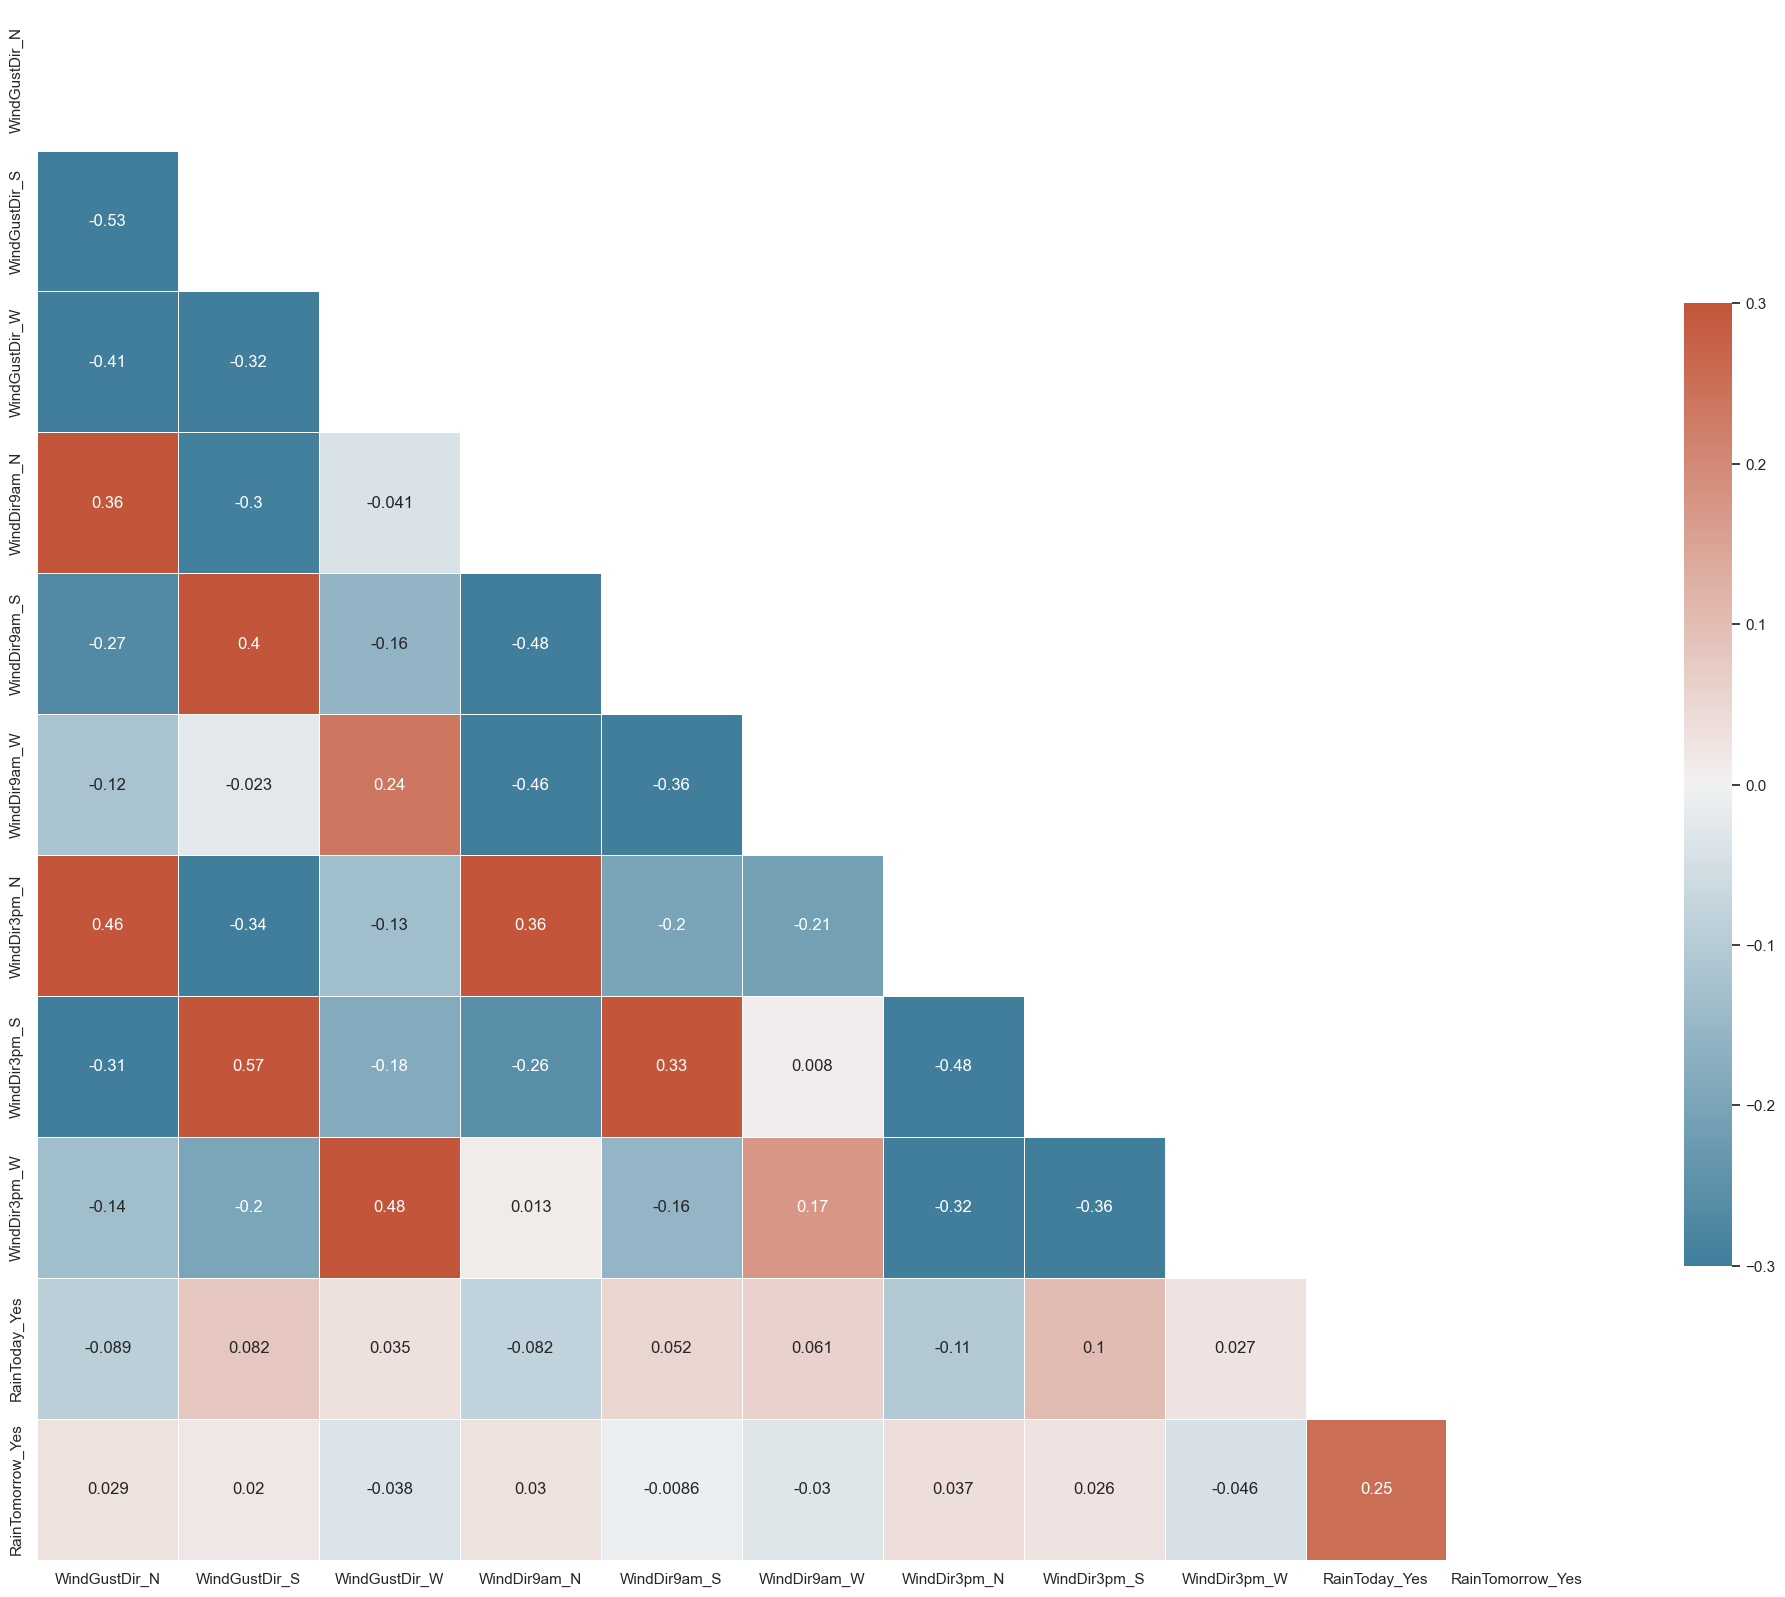

In [ ]:
sns.set_theme(style="white")

# Calcular la matriz de correlación
corr = train_dummies[['WindGustDir_N', 'WindGustDir_S', 'WindGustDir_W', 'WindDir9am_N', 'WindDir9am_S', 'WindDir9am_W', 'WindDir3pm_N', 'WindDir3pm_S', 'WindDir3pm_W', 'RainToday_Yes', 'RainTomorrow_Yes']].corr()

# Generar una máscara para el triángulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Configurar la figura de matplotlib
f, ax = plt.subplots(figsize=(25, 25))

# Generar un colormap diverging personalizado
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Dibujar el heatmap con la máscara y el aspecto correcto
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-.3 ,vmax=.3, center=0, square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

Realizo la matriz de correlación solo en el conjunto de entrenamiento (train) para evitar el **data leakage**, que sucede cuando se emplea información del conjunto de prueba (test) para tomar decisiones durante el entrenamiento del modelo.

## Estandarización
Estandarizamos las características porque pueden tener diferentes rangos de valores.
Estandarizarlas asegura que todas las características tengan la misma escala, lo que evita que las características
con mayores rangos dominen el modelo.

In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


In [40]:
# Seleccionar solo columnas numéricas
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
print("Columnas numéricas:", numeric_cols)


Columnas numéricas: Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainfallTomorrow'],
      dtype='object')


In [41]:

# Definir las columnas a estandarizar
columns_to_standardize = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm', 'RainfallTomorrow'
]

# Función para aplicar estandarización
def standardize_data(train_dummies, test_dummies, columns):

    # Ajustar y transformar en el conjunto de entrenamiento
    train_dummies[columns] = scaler.fit_transform(train_dummies[columns])

    # Transformar el conjunto de prueba con los mismos parámetros que en el de entrenamiento
    test_dummies[columns] = scaler.transform(test_dummies[columns])

    print("Estandarización completada en train y test.")

# Aplicar estandarización
standardize_data(train_dummies, test_dummies, columns_to_standardize)


Estandarización completada en train y test.


In [42]:
import joblib

# Definir la ruta donde se guardará el scaler
scaler_path = 'docker/model/scaler.joblib'

# Guardar el scaler usando joblib
joblib.dump(scaler, scaler_path)

print(f"Scaler guardado en: {scaler_path}")


Scaler guardado en: docker/model/scaler.joblib


**En el conjunto de entrenamiento:**  
Se usa `fit_transform` de `StandardScaler` para calcular la media y desviación estándar de los datos y aplicar la transformación en una sola operación.  

**En el conjunto de prueba:**  
Se utiliza `transform` para escalar los datos de prueba con los mismos parámetros obtenidos del conjunto de entrenamiento, garantizando coherencia en la transformación.  

Esto evita la fuga de información (*data leakage*) y asegura una estandarización consistente entre ambos conjuntos.


## División del conjunto de datos de entrenamiento


Clasificación (x_train_c, x_test_c)

- Elimino RainTomorrow_Yes (porque es la variable objetivo).
- Elimino RainfallTomorrow (porque si el modelo la ve, tendría información directa sobre la lluvia, lo que haría que la clasificación pierda sentido).

Regresión (x_train_rl, x_test_rl)

- Elimino RainTomorrow_Yes (porque es una variable categórica que no aporta a la regresión).
- Elimino RainfallTomorrow (porque es la variable objetivo).

In [43]:
# Clasificación (RainTomorrow)
y_train_c = train_dummies['RainTomorrow_Yes']
x_train_c = train_dummies.drop(['RainTomorrow_Yes', 'RainfallTomorrow'], axis=1)  # Eliminamos ambas
y_test_c = test_dummies['RainTomorrow_Yes']
x_test_c = test_dummies.drop(['RainTomorrow_Yes', 'RainfallTomorrow'], axis=1)


In [44]:
y_train_c

0        0
1        0
2        0
3        0
4        0
        ..
69465    0
69466    0
69467    1
69468    0
69469    0
Name: RainTomorrow_Yes, Length: 14570, dtype: int64

In [45]:
# Regresión (RainfallTomorrow)
y_train_rl = train_dummies['RainfallTomorrow']
x_train_rl = train_dummies.drop(['RainTomorrow_Yes', 'RainfallTomorrow'], axis=1)  # Eliminamos ambas
y_test_rl = test_dummies['RainfallTomorrow']
x_test_rl = test_dummies.drop(['RainTomorrow_Yes', 'RainfallTomorrow'], axis=1)

# Revisar que n

In [46]:
x_test_c.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3639 entries, 2393 to 70370
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           3639 non-null   int64  
 1   MinTemp        3639 non-null   float64
 2   MaxTemp        3639 non-null   float64
 3   Rainfall       3639 non-null   float64
 4   Evaporation    3639 non-null   float64
 5   Sunshine       3639 non-null   float64
 6   WindGustSpeed  3639 non-null   float64
 7   WindSpeed9am   3639 non-null   float64
 8   WindSpeed3pm   3639 non-null   float64
 9   Humidity9am    3639 non-null   float64
 10  Humidity3pm    3639 non-null   float64
 11  Pressure9am    3639 non-null   float64
 12  Pressure3pm    3639 non-null   float64
 13  Cloud9am       3639 non-null   float64
 14  Cloud3pm       3639 non-null   float64
 15  Temp9am        3639 non-null   float64
 16  Temp3pm        3639 non-null   float64
 17  WindGustDir_N  3639 non-null   int64  
 18  WindGustD

In [47]:
x_train_rl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14570 entries, 0 to 69469
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           14570 non-null  int64  
 1   MinTemp        14570 non-null  float64
 2   MaxTemp        14570 non-null  float64
 3   Rainfall       14570 non-null  float64
 4   Evaporation    14570 non-null  float64
 5   Sunshine       14570 non-null  float64
 6   WindGustSpeed  14570 non-null  float64
 7   WindSpeed9am   14570 non-null  float64
 8   WindSpeed3pm   14570 non-null  float64
 9   Humidity9am    14570 non-null  float64
 10  Humidity3pm    14570 non-null  float64
 11  Pressure9am    14570 non-null  float64
 12  Pressure3pm    14570 non-null  float64
 13  Cloud9am       14570 non-null  float64
 14  Cloud3pm       14570 non-null  float64
 15  Temp9am        14570 non-null  float64
 16  Temp3pm        14570 non-null  float64
 17  WindGustDir_N  14570 non-null  int64  
 18  WindGustDir

## Balanceo de datos
Realizamos un balanceo de datos en el conjunto de entrenamiento utilizando la técnica SMOTETomek.


In [48]:
from imblearn.combine import SMOTETomek

# Aplicar SMOTETomek solo al conjunto de entrenamiento
smote_tomek = SMOTETomek(random_state=42)

In [49]:
# Asegurarse de que y_train no sea un DataFrame
if isinstance(y_train_c, pd.DataFrame):
    y_train_c = y_train_c.iloc[:, 0]

# Reemplazar directamente X_train y y_train con los datos balanceados
x_train_c, y_train_c = smote_tomek.fit_resample(x_train_c, y_train_c)

# El conjunto de prueba se mantiene sin cambios
x_test_c, y_test_c = x_test_c, y_test_c  # No hacemos nada con X_test ni y_test

# Verificar las formas de los datos balanceados
print("Tamaño de X_train después de SMOTETomek:", x_train_c.shape)
print("Tamaño de y_train después de SMOTETomek:", y_train_c.shape)
print("Tamaño de X_test (sin cambios):", x_test_c.shape)
print("Tamaño de y_test (sin cambios):", y_test_c.shape)

print("x_train_rl shape:", x_train_c.shape)
print("y_train_rl shape:", y_train_c.shape)


print("\nDistribución después del balanceo:")
print(pd.Series(y_train_c).value_counts(normalize=True))


Tamaño de X_train después de SMOTETomek: (22214, 27)
Tamaño de y_train después de SMOTETomek: (22214,)
Tamaño de X_test (sin cambios): (3639, 27)
Tamaño de y_test (sin cambios): (3639,)
x_train_rl shape: (22214, 27)
y_train_rl shape: (22214,)

Distribución después del balanceo:
RainTomorrow_Yes
0    0.5
1    0.5
Name: proportion, dtype: float64


El método **SMOTETomek** combina **SMOTE**, que genera muestras sintéticas para la clase minoritaria, con **Tomek Links**, que elimina instancias redundantes de la clase mayoritaria. Esta combinación no solo equilibra el conjunto de datos, sino que también reduce el ruido, mejorando la calidad del aprendizaje.  

Su uso está justificado porque:  
1. **Corrige el desbalance de clases**, evitando que el modelo favorezca la clase mayoritaria.  
2. **Optimiza el aprendizaje**, definiendo mejor los límites de decisión y mejorando métricas como sensibilidad y F1-Score.  
3. **Favorece la generalización**, proporcionando un conjunto de entrenamiento más representativo.  

El conjunto de prueba se mantiene sin modificaciones para evaluar el modelo con la distribución real de los datos y garantizar una evaluación objetiva.

## Regresion Lineal

In [50]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [51]:
# Evaluación en conjunto de entrenamiento
def evaluate_model(y_true, y_pred, dataset="Train"):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"\n=== Métricas del set de {dataset} ===")
    print(f"R²: {r2:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")



In [52]:
from sklearn.linear_model import LinearRegression

print("\n=== Regresión Lineal ===")
model_rl = LinearRegression()
model_rl.fit(x_train_rl, y_train_rl)

y_train_pred = model_rl.predict(x_train_rl)
y_test_pred = model_rl.predict(x_test_rl)

print("\nCoeficientes:", model_rl.coef_)
print("Intercepto:", model_rl.intercept_)

evaluate_model(y_train_rl, y_train_pred, dataset="Entrenamiento")
evaluate_model(y_test_rl, y_test_pred, dataset="Prueba")




=== Regresión Lineal ===

Coeficientes: [ 3.28164994e-06 -7.28819749e-02  5.52740621e-02  1.56584294e-01
 -3.75356247e-03 -1.19775130e-01  2.19709046e-01 -9.76476847e-03
 -9.65586494e-02 -4.22436140e-02  3.93298926e-01  3.44582266e-01
 -3.90875513e-01 -4.05520872e-02  2.18225724e-02 -8.82401850e-03
  1.13735100e-01 -8.93341860e-02 -7.77168976e-02 -1.08514350e-01
 -1.21133774e-01 -5.05897194e-02 -9.26331235e-02 -1.63797485e-02
  5.31441501e-02  8.00918714e-02  3.64670424e-02]
Intercepto: 0.11262259851584373

=== Métricas del set de Entrenamiento ===
R²: 0.2185
MSE: 0.7815
MAE: 0.4224
RMSE: 0.8840

=== Métricas del set de Prueba ===
R²: 0.2623
MSE: 0.7768
MAE: 0.4351
RMSE: 0.8814


## Gradiente Descendiente

In [53]:
from sklearn.ensemble import GradientBoostingRegressor

print("\n=== Regresión con Gradient Boosting ===")
model_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model_gb.fit(x_train_rl, y_train_rl.ravel())

y_train_pred_gb = model_gb.predict(x_train_rl)
y_test_pred_gb = model_gb.predict(x_test_rl)

# Importancia de características
print("\nImportancia de características:")
print(model_gb.feature_importances_)

# Evaluación del modelo
evaluate_model(y_train_rl, y_train_pred_gb, dataset="Entrenamiento (GB)")
evaluate_model(y_test_rl, y_test_pred_gb, dataset="Prueba (GB)")



=== Regresión con Gradient Boosting ===


C:\Users\brisa\AppData\Local\Temp\ipykernel_2188\2636122481.py:5: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  model_gb.fit(x_train_rl, y_train_rl.ravel())



Importancia de características:
[1.01960286e-02 1.36835677e-02 9.42091386e-03 7.93430802e-02
 1.59165654e-02 6.36796323e-02 1.04833863e-01 1.58508646e-02
 1.90155438e-02 8.08962135e-03 5.22381658e-01 2.93749775e-02
 1.95738029e-02 6.91330510e-03 6.89783653e-03 2.96361994e-02
 3.33069088e-02 7.18801190e-04 2.12373906e-03 7.78650855e-04
 3.35013899e-04 2.05054639e-03 5.44598024e-04 4.43329802e-04
 2.74400967e-03 6.50002842e-04 1.49693889e-03]

=== Métricas del set de Entrenamiento (GB) ===
R²: 0.4751
MSE: 0.5249
MAE: 0.3055
RMSE: 0.7245

=== Métricas del set de Prueba (GB) ===
R²: 0.2978
MSE: 0.7394
MAE: 0.3551
RMSE: 0.8599


In [54]:
import joblib

model_name = "modelRGD.joblib"
model_path = f'docker/model/{model_name}'

# Guardar el modelo
joblib.dump(model_gb, model_path)

print(f'Modelo guardado en: {model_path}')


Modelo guardado en: docker/model/modelRGD.joblib


(GBR) es un modelo de ensamble basado en gradiente descendente que construye una serie de árboles de decisión secuenciales. Cada árbol aprende de los errores del árbol anterior para mejorar la predicción.

- Utilice Gradient Boosting ya que aprende de manera iterativa, mejorando el modelo con cada paso. Puede manejar relaciones no lineales mejor que una regresión lineal tradicional. Es menos sensible a outliers comparado con métodos de gradiente como SGDRegressor, este mismo lo implemente previamente pero daba demasiado mal, el Gradient Boosting es menos sensible a los outlaires y mas flexible en el manejo de los hiperparametros y sus resultados fueron mucho mejor.

## Regularización


In [55]:
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [56]:
print("\n=== Regresión con Regularización ===")
for model_name, model in zip(["Lasso", "Ridge", "ElasticNet"],
                             [Lasso(alpha=0.001), Ridge(alpha=1.0), ElasticNet(alpha=0.001, l1_ratio=0.5)]):
    print(f"\n--- {model_name} ---")
    model.fit(x_train_rl, y_train_rl.ravel())

    y_train_pred_reg = model.predict(x_train_rl)
    y_test_pred_reg = model.predict(x_test_rl)

    evaluate_model(y_train_rl, y_train_pred_reg, dataset=f"Entrenamiento ({model_name})")
    evaluate_model(y_test_rl, y_test_pred_reg, dataset=f"Prueba ({model_name})")



=== Regresión con Regularización ===

--- Lasso ---


C:\Users\brisa\AppData\Local\Temp\ipykernel_2188\743789172.py:5: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  model.fit(x_train_rl, y_train_rl.ravel())



=== Métricas del set de Entrenamiento (Lasso) ===
R²: 0.2181
MSE: 0.7819
MAE: 0.4196
RMSE: 0.8842

=== Métricas del set de Prueba (Lasso) ===
R²: 0.2610
MSE: 0.7781
MAE: 0.4322
RMSE: 0.8821

--- Ridge ---

=== Métricas del set de Entrenamiento (Ridge) ===
R²: 0.2185
MSE: 0.7815
MAE: 0.4224
RMSE: 0.8840

=== Métricas del set de Prueba (Ridge) ===
R²: 0.2622
MSE: 0.7769
MAE: 0.4351
RMSE: 0.8814

--- ElasticNet ---


C:\Users\brisa\AppData\Local\Temp\ipykernel_2188\743789172.py:5: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  model.fit(x_train_rl, y_train_rl.ravel())
C:\Users\brisa\AppData\Local\Temp\ipykernel_2188\743789172.py:5: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  model.fit(x_train_rl, y_train_rl.ravel())



=== Métricas del set de Entrenamiento (ElasticNet) ===
R²: 0.2184
MSE: 0.7816
MAE: 0.4207
RMSE: 0.8841

=== Métricas del set de Prueba (ElasticNet) ===
R²: 0.2616
MSE: 0.7776
MAE: 0.4333
RMSE: 0.8818


- Los modelos con regularización (Lasso, Ridge y ElasticNet) tienen un rendimiento similar, con R² alrededor de 0.58 en entrenamiento y 0.50 en prueba, indicando que capturan cierta variabilidad. Ridge y ElasticNet destacan ligeramente, y Lasso mantiene un buen desempeño sin eliminar variables clave. La pequeña diferencia entre R² de entrenamiento y prueba sugiere que no hay sobreajuste.

## Clasificacion

In [57]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [58]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Inicializar el modelo de Regresión Logística
model_rlog = LogisticRegression(max_iter=500)

# Entrenamiento y medición del tiempo
start = time.time()
model_rlog.fit(x_train_c, y_train_c.ravel())
end = time.time()
training_time = end - start

# Predicciones
y_pred_train = model_rlog.predict(x_train_c)
y_pred_test = model_rlog.predict(x_test_c)

# Función para evaluar el modelo
def evaluate_classification(y_true, y_pred, dataset="Train"):
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred)

    print(f"\n=== Métricas para {dataset} ===")
    print(f'Precisión: {accuracy:.4f}')
    print("Matriz de confusión:\n", conf_matrix)
    print("Reporte de clasificación:\n", class_report)

# Evaluación
evaluate_classification(y_train_c, y_pred_train, dataset="Entrenamiento")
evaluate_classification(y_test_c, y_pred_test, dataset="Prueba")

# Mostrar tiempo de entrenamiento
print(f"\nTiempo de entrenamiento: {training_time:.4f} segundos")


C:\Users\brisa\AppData\Local\Temp\ipykernel_2188\2817807590.py:10: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  model_rlog.fit(x_train_c, y_train_c.ravel())



=== Métricas para Entrenamiento ===
Precisión: 0.8336
Matriz de confusión:
 [[9405 1702]
 [1994 9113]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.83      0.85      0.84     11107
           1       0.84      0.82      0.83     11107

    accuracy                           0.83     22214
   macro avg       0.83      0.83      0.83     22214
weighted avg       0.83      0.83      0.83     22214


=== Métricas para Prueba ===
Precisión: 0.7947
Matriz de confusión:
 [[2292  511]
 [ 236  600]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.91      0.82      0.86      2803
           1       0.54      0.72      0.62       836

    accuracy                           0.79      3639
   macro avg       0.72      0.77      0.74      3639
weighted avg       0.82      0.79      0.80      3639


Tiempo de entrenamiento: 2.5039 segundos


c:\Users\brisa\OneDrive\Desktop\Tp-libre-AA1\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [61]:
report = classification_report(y_test_c, y_pred_test, output_dict=True)
print("Clase positiva (1):", report["1"])
print("Clase negativa (0):", report["0"])

Clase positiva (1): {'precision': 0.54005400540054, 'recall': 0.7177033492822966, 'f1-score': 0.6163328197226502, 'support': 836.0}
Clase negativa (0): {'precision': 0.9066455696202531, 'recall': 0.8176953264359614, 'f1-score': 0.8598761958356781, 'support': 2803.0}


Obtuvimos un f1-score de 0.71 para la clase positiva, lo que indica que el modelo no está clasificando bien la clase positiva.

In [64]:
# Definir la ruta donde se guardará el modelo
model_name = "modelRLOG.joblib"
model_path = f'docker/model/{model_name}'

# Guardar el modelo
joblib.dump(model_rlog, model_path)

print(f'Modelo guardado en: {model_path}')




Modelo guardado en: docker/model/modelRLOG.joblib


## Curva ROC

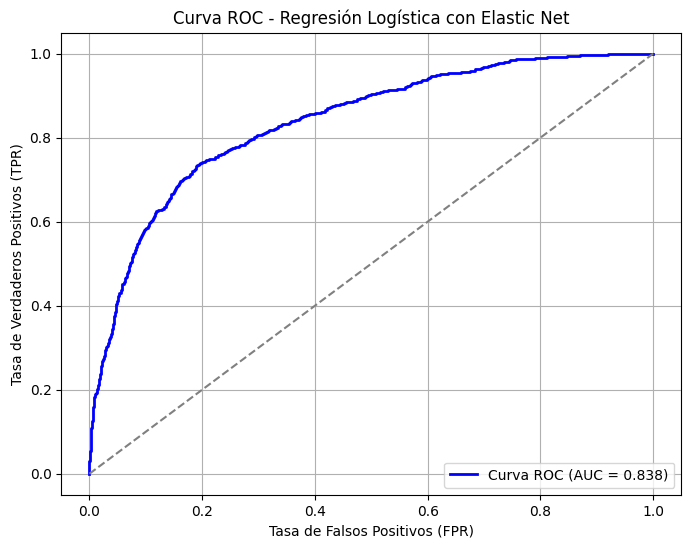

Umbral óptimo para prueba: 0.4756


In [63]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Obtener probabilidades de la clase positiva
y_scores = model_rlog.predict_proba(x_test_c)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test_c, y_scores)
roc_auc = auc(fpr, tpr)  # Área bajo la curva

# Gráfica de la Curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal (modelo aleatorio)
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Regresión Logística con Elastic Net')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Encontrar el umbral óptimo (máximo equilibrio entre sensibilidad y especificidad)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Umbral óptimo para prueba: {optimal_threshold:.4f}")


- Un AUC de 0.84 significa que el modelo tiene un desempeño aceptable,  pero todavía podría mejorarse para reducir errores en la clasificación.

- El umbral óptimo (0.4756) representa la proporción a partir de la cual el modelo predice que lloverá al día siguiente. Es decir, si la probabilidad predicha de lluvia es mayor o igual a 0.48, el modelo clasifica el día como lluvioso; de lo contrario, lo clasifica como no lluvioso.

## Red neuronal

### Clasificación

In [129]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from keras.metrics import Accuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
import optuna
import shap
import joblib
from tensorflow.keras.models import Model


In [130]:


# Crear la red neuronal
model = Sequential([
    Dense(64, activation='relu', input_shape=(x_train_c.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Separar los datos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(x_train_c, y_train_c, test_size=0.2, random_state=42)

# Entrenar el modelo y guardar la historia del entrenamiento
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),  # Usar datos de validación separados
                    epochs=50,
                    batch_size=20,
                    verbose=1)

# Evaluar el modelo en los datos de prueba
loss, accuracy = model.evaluate(x_test_c, y_test_c)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Realizar predicciones
predictions = model.predict(x_test_c)
pred = (predictions > 0.5).astype(int)  # Clasificación binaria

# Calcular F1 Score para el modelo no optimizado
f1_score_unoptimized = f1_score(y_test_c, pred)
print(f"F1 Score for the unoptimized model: {f1_score_unoptimized:.2f}")


c:\Users\brisa\OneDrive\Desktop\Tp-libre-AA1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5625 - loss: 3.4149 - val_accuracy: 0.7810 - val_loss: 0.6623
Epoch 2/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6859 - loss: 1.4264 - val_accuracy: 0.6511 - val_loss: 1.6319
Epoch 3/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6713 - loss: 2.1007 - val_accuracy: 0.8100 - val_loss: 0.6336
Epoch 4/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7177 - loss: 1.3035 - val_accuracy: 0.6424 - val_loss: 1.6995
Epoch 5/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7251 - loss: 1.1673 - val_accuracy: 0.7925 - val_loss: 0.6129
Epoch 6/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7384 - loss: 1.0246 - val_accuracy: 0.5030 - val_loss: 5.7099
Epoch 7/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7313 - loss: 1.1534 - val_accuracy: 0.7324 - val_loss: 0.8916
Epoch 8/50
889/889 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7401 - loss: 1.0181 - val_accuracy: 0.

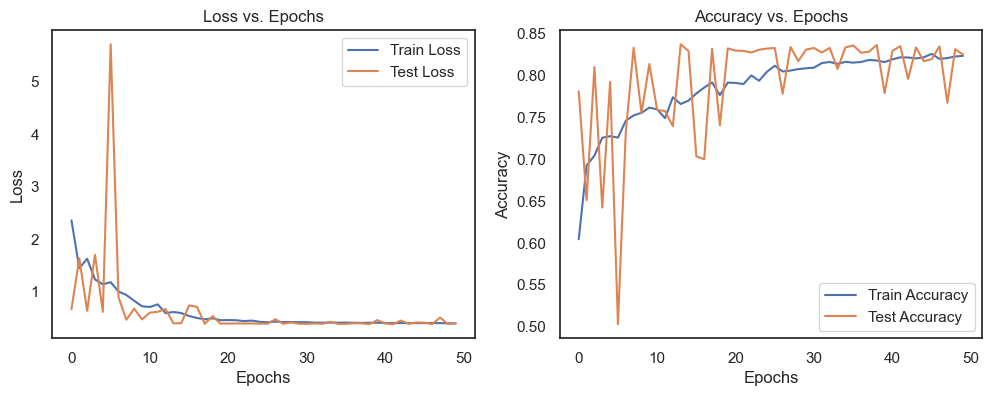

In [132]:
# Graficar la pérdida y la precisión a lo largo del entrenamiento
plt.figure(figsize=(12, 4))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()

plt.show()


#### Optuna para optimización de hiperparámetros

In [133]:
import optuna
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def objective(trial):
    # Hiperparámetros a optimizar
    n_layers = trial.suggest_int('n_layers', 1, 2)  # Reducir el número de capas para acelerar
    n_units = trial.suggest_int('n_units', 32, 64)  # Reducir el rango de unidades
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)  # Establecer un rango adecuado para el dropout
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)  # Restringir el rango de tasa de aprendizaje

    # Crear la red neuronal con los hiperparámetros sugeridos
    inputs = Input(shape=(x_train_c.shape[1],))
    x = Dense(n_units, activation='relu')(inputs)
    x = Dropout(dropout_rate)(x)

    for i in range(n_layers - 1):
        x = Dense(n_units, activation='relu')(x)
        x = Dropout(dropout_rate)(x)

    outputs = Dense(1, activation='sigmoid')(x)
    model_ho = Model(inputs=inputs, outputs=outputs)

    # Compilar el modelo
    model_ho.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    # Early stopping para evitar entrenamientos largos
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=0)

    # Entrenar el modelo con EarlyStopping
    history = model_ho.fit(
        x_train_c, y_train_c,
        validation_data=(x_test_c, y_test_c),
        epochs=50, batch_size=20, verbose=0,
        callbacks=[early_stopping]  # Usar early stopping
    )

    # Evaluación del modelo
    loss, accuracy = model_ho.evaluate(x_test_c, y_test_c, verbose=0)
    return loss

# Crear el estudio de Optuna y empezar la optimización
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

# Obtener los mejores hiperparámetros
best_params = study.best_params
print("Best parámetros encontrados:", best_params)


[I 2025-02-23 00:18:06,733] A new study created in memory with name: no-name-1bd7642b-910d-4ce0-8931-eb4cb2449c47
[I 2025-02-23 00:18:30,810] Trial 0 finished with value: 0.6894075274467468 and parameters: {'n_layers': 2, 'n_units': 38, 'dropout_rate': 0.2968181849039425, 'learning_rate': 0.0009109052283337295}. Best is trial 0 with value: 0.6894075274467468.
[I 2025-02-23 00:18:53,410] Trial 1 finished with value: 0.6060720682144165 and parameters: {'n_layers': 2, 'n_units': 55, 'dropout_rate': 0.42408301080998256, 'learning_rate': 0.0008715544135408567}. Best is trial 1 with value: 0.6060720682144165.
[I 2025-02-23 00:19:11,558] Trial 2 finished with value: 0.5273710489273071 and parameters: {'n_layers': 1, 'n_units': 40, 'dropout_rate': 0.30507689987771225, 'learning_rate': 0.00014132936241672623}. Best is trial 2 with value: 0.5273710489273071.
[I 2025-02-23 00:19:30,921] Trial 3 finished with value: 0.6828187108039856 and parameters: {'n_layers': 2, 'n_units': 45, 'dropout_rate': 

Best parámetros encontrados: {'n_layers': 1, 'n_units': 42, 'dropout_rate': 0.34018555582199284, 'learning_rate': 0.0014918517445244024}


#### Entrenamiento con los mejores hiperparámetros

In [134]:
# Hiperparámetros optimizados
n_layers = best_params['n_layers']
n_units = best_params['n_units']
dropout_rate = best_params['dropout_rate']
learning_rate = best_params['learning_rate']

# Crear el modelo con los mejores hiperparámetros
model_ho = Sequential()
model_ho.add(Dense(n_units, activation='relu', input_shape=(x_train_c.shape[1],)))
model_ho.add(Dropout(dropout_rate))

for _ in range(n_layers - 1):
    model_ho.add(Dense(n_units, activation='relu'))
    model_ho.add(Dropout(dropout_rate))

model_ho.add(Dense(1, activation='sigmoid'))

# Compilar el modelo con la tasa de aprendizaje optimizada
optimizer = Adam(learning_rate=learning_rate)
model_ho.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history_ho = model_ho.fit(x_train_c, y_train_c, validation_data=(x_test_c, y_test_c), epochs=50, batch_size=20)

# Predicciones para el modelo optimizado
pred_ho = (model_ho.predict(x_test_c) > 0.5).astype(int)  # Clasificación binaria

# Reporte de clasificación
classification_report_logreg_ho = classification_report(y_test_c, pred_ho, zero_division=1)
print("Reporte de clasificación:")
print(classification_report_logreg_ho)


Epoch 1/50


c:\Users\brisa\OneDrive\Desktop\Tp-libre-AA1\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1111/1111 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5176 - loss: 88.2534 - val_accuracy: 0.4075 - val_loss: 0.7558
Epoch 2/50
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6404 - loss: 0.6553 - val_accuracy: 0.7002 - val_loss: 0.6306
Epoch 3/50
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6669 - loss: 0.6341 - val_accuracy: 0.8005 - val_loss: 0.4356
Epoch 4/50
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6583 - loss: 0.6163 - val_accuracy: 0.7700 - val_loss: 0.5143
Epoch 5/50
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7304 - loss: 0.5532 - val_accuracy: 0.7216 - val_loss: 0.6455
Epoch 6/50
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6953 - loss: 0.5867 - val_accuracy: 0.7392 - val_loss: 0.6050
Epoch 7/50
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7088 - loss: 0.5730 - val_accuracy: 0.8211 - val_loss: 0.5376
Epoch 8/50
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6858 - loss: 0.5858 - val_accura

### SHAP para explicabilidad local y global

Explicabilidad local


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
6569/6569 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step


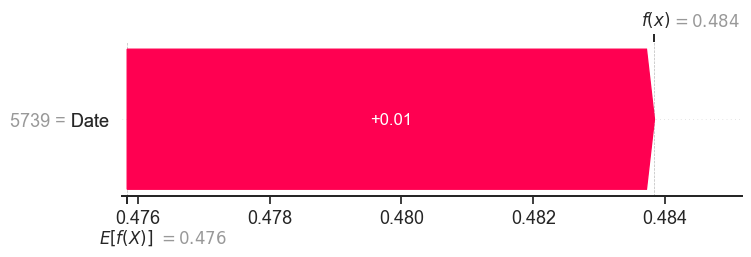

In [140]:
import shap

# Definir el conjunto de datos de referencia (background) como un subconjunto de datos de entrenamiento
background = x_train_c.sample(100) 
# Crear el objeto explainer SHAP
explainer = shap.KernelExplainer(model_ho.predict, background)

# Calcular los valores SHAP para la primera instancia de prueba
instance_to_explain = x_test_c.iloc[0:1].values  # Seleccionar la línea 0
shap_values = explainer.shap_values(instance_to_explain)

# Visualizar la explicación de las importancias de las características
shap.initjs()

# Asegúrate de que shap_values tiene la forma correcta para una sola instancia
shap_values_explanation = shap.Explanation(values=shap_values[0][0],  # Solo la primera explicación
                                            base_values=explainer.expected_value,
                                            data=instance_to_explain[0],
                                            feature_names=x_test_c.columns)

# Usar el objeto Explanation en shap.plots.waterfall()
shap.plots.waterfall(shap_values_explanation)  # Visualizar el gráfico de cascada


Explicabilidad global



PermutationExplainer explainer: 3640it [05:43, 10.59it/s]


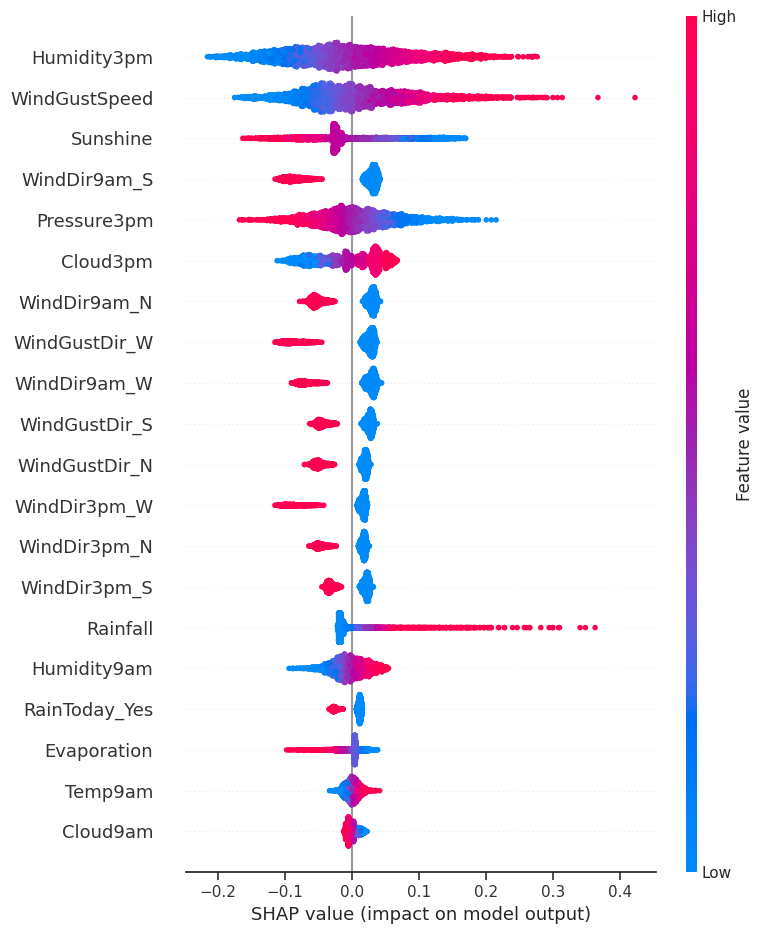

In [ ]:
# Crear el objeto PermutationExplainer
explainer = shap.Explainer(model_ho, x_test_c, algorithm='permutation')

# Obtener los valores SHAP para el conjunto de prueba
shap_values = explainer(x_test_c)

# Visualizar los valores SHAP
shap.summary_plot(shap_values, x_test_c)


## Regresion lineal- redes

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import shap
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
# Definimos el modelo de red neuronal
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(x_train_rl.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)  # Capa de salida para regresión
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
456/456 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 802.3748 - mae: 12.3099 - val_loss: 1.3311 - val_mae: 0.6757
Epoch 2/100
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.0327 - mae: 0.5608 - val_loss: 1.2461 - val_mae: 0.8861
Epoch 3/100
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.2104 - mae: 0.6523 - val_loss: 1.0873 - val_mae: 0.5735
Epoch 4/100
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.2411 - mae: 0.7205 - val_loss: 0.9557 - val_mae: 0.6674
Epoch 5/100
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.4320 - mae: 0.8095 - val_loss: 3.7943 - val_mae: 1.7279
Epoch 6/100
456/456 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3.9948 - mae: 1.4765 - val_loss: 2.2064 - val_mae: 1.1923
Epoch 7/100
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 5.5052 - mae: 1.8183 - val_loss: 0.9251 - val_mae: 0.6442
Epoch 8/100
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 6.1897 - mae: 1.8098 - val_loss: 2.5488 - val_mae: 1.3255
Epoch 9/100
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 5

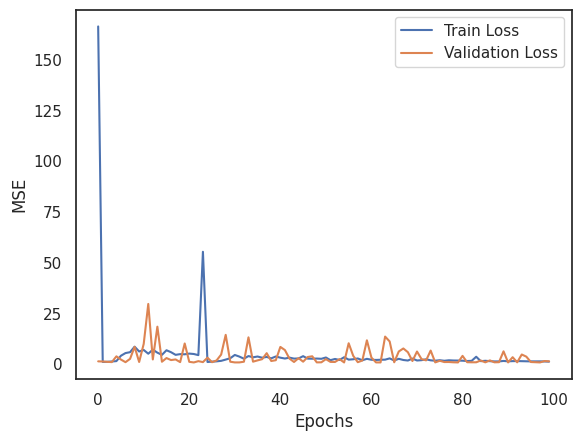

In [ ]:

# Compilamos el modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Entrenamos el modelo
history = model.fit(x_train_rl, y_train_rl, epochs=100, batch_size=32, validation_data=(x_test_rl, y_test_rl), verbose=1)

# Evaluamos el modelo
eval_result = model.evaluate(x_test_rl, y_test_rl)
print(f"MSE: {eval_result[0]}, MAE: {eval_result[1]}")

# Visualización del proceso de entrenamiento
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()


- Optuna redes regresionlineal

In [ ]:
def objective(trial):
    num_units_1 = trial.suggest_int('num_units_1', 32, 128)
    num_units_2 = trial.suggest_int('num_units_2', 16, 64)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-3)
    batch_size = trial.suggest_categorical('batch_size', [32, 64])

    model = keras.Sequential([
        layers.Dense(num_units_1, activation='relu', input_shape=(x_train_rl.shape[1],)),
        layers.Dropout(0.2),  # Agregamos Dropout para regularización
        layers.Dense(num_units_2, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])

    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(x_train_rl, y_train_rl, epochs=50, batch_size=batch_size,
                        validation_data=(x_test_rl, y_test_rl), verbose=0, callbacks=[early_stopping])

    eval_result = model.evaluate(x_test_rl, y_test_rl, verbose=0)
    return eval_result[0]

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

best_params = study.best_params
print(f"Mejores hiperparámetros: {best_params}")

# Entrenamos el modelo final con los mejores hiperparámetros
model = keras.Sequential([
    layers.Dense(best_params['num_units_1'], activation='relu', input_shape=(x_train_rl.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(best_params['num_units_2'], activation='relu'),
    layers.Dense(1)
])




[I 2025-02-21 22:14:42,492] A new study created in memory with name: no-name-a379300d-a63f-47cd-97f3-974342ee733f
<ipython-input-820-495559c2b886>:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 5e-3)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-02-21 22:15:32,436] Trial 0 finished with value: 1.0928670167922974 and parameters: {'num_units_1': 75, 'num_units_2': 43, 'learning_rate': 0.00014444286297018552, 'batch_size': 32}. Best is trial 0 with value: 1.0928670167922974.
<ip

Mejores hiperparámetros: {'num_units_1': 89, 'num_units_2': 20, 'learning_rate': 9.354407864724564e-05, 'batch_size': 32}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
456/456 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 54407.8359 - mae: 182.3466 - val_loss: 99.6114 - val_mae: 9.9204
Epoch 2/100
456/456 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 16150.4062 - mae: 98.5697 - val_loss: 969.4685 - val_mae: 31.1045
Epoch 3/100
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 8440.9639 - mae: 71.6198 - val_loss: 153.3085 - val_mae: 12.3317
Epoch 4/100
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 5425.1270 - mae: 57.2448 - val_loss: 2.1032 - val_mae: 1.2840
Epoch 5/100
456/456 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 3667.6365 - mae: 47.3034 - val_loss: 223.7818 - val_mae: 14.9145
Epoch 6/100
456/456 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2409.5151 - mae: 38.0313 - val_loss: 252.5662 - val_mae: 15.8494
Epoch 7/100
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1473.7355 - mae: 29.6930 - val_loss: 764.3932 - val_mae: 27.6158
Epoch 8/100
456/456 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 959.1601 - mae: 23.5742 - val_loss: 134.9183 - val_mae: 11

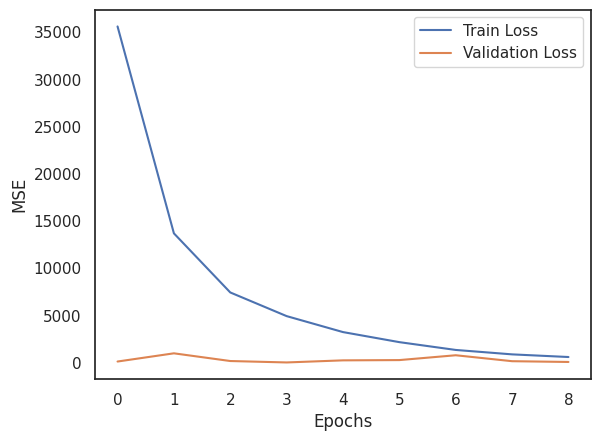

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=best_params['learning_rate']), loss='mse', metrics=['mae'])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(x_train_rl, y_train_rl, epochs=100, batch_size=best_params['batch_size'],
                    validation_data=(x_test_rl, y_test_rl), verbose=1, callbacks=[early_stopping])

eval_result = model.evaluate(x_test_rl, y_test_rl)
print(f"MSE: {eval_result[0]}, MAE: {eval_result[1]}")

# Visualizar pérdidas
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

  0%|          | 0/1 [00:00<?, ?it/s]

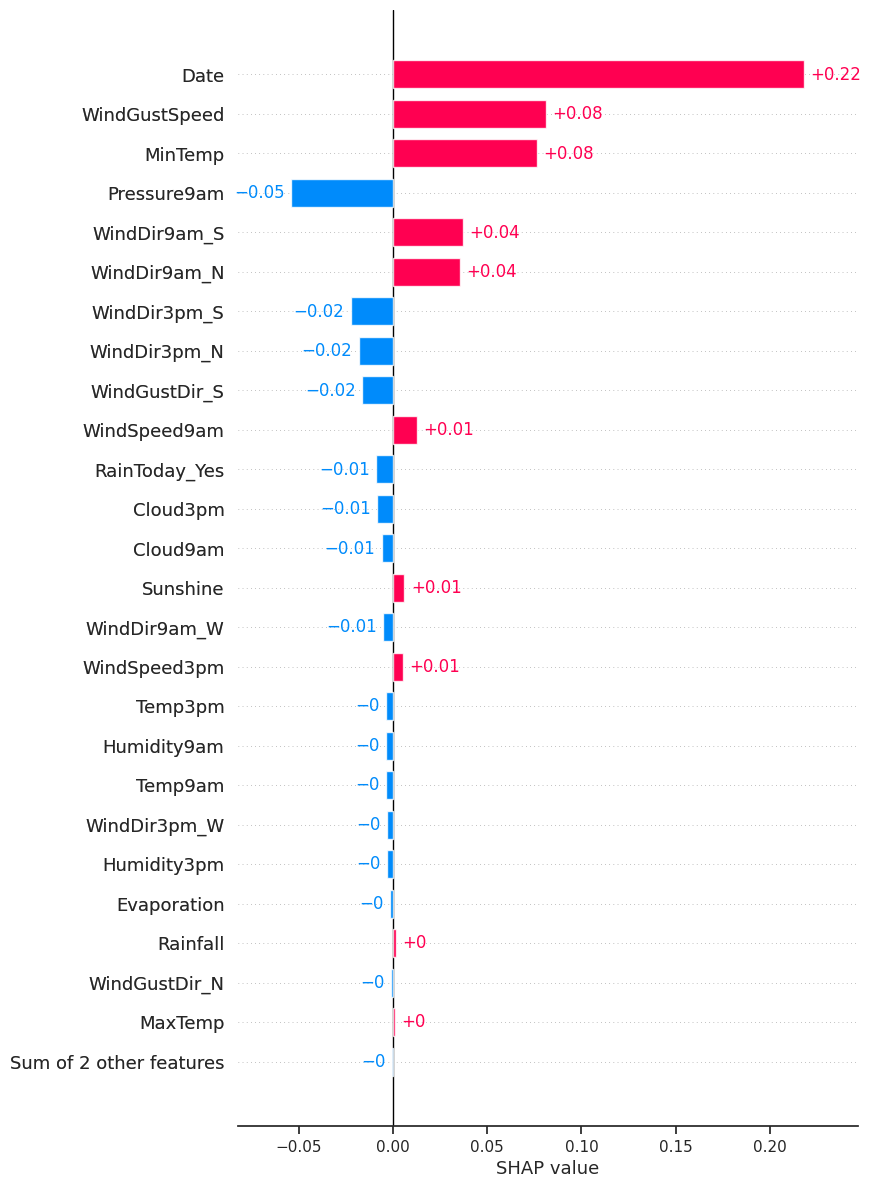

In [ ]:

# SHAP para explicabilidad
feature_names = x_train_rl.columns.values
background = x_train_rl.sample(100)
explainer = shap.KernelExplainer(model, background)
instance_to_explain = x_test_rl.iloc[0:1].values

shap_values = explainer.shap_values(instance_to_explain)
shap_values = shap_values.reshape(27,)
expected_value = explainer.expected_value

# Visualizar la explicación
shap.initjs()
shap.plots.bar(shap.Explanation(values=shap_values, base_values=expected_value, feature_names=feature_names), max_display=26)



# Comparación de los modelos

| **Modelo**          | **MSE**    |
|---------------------|-----------|
| Regresión Lineal   | 0.7768    |
| Gradiente Descendente | 0.7394    |
| Elastic Net        | 0.7776    |
| Ridge             | 0.7769    |
| Lasso             | 0.7781    |
| Redes Neuronales  | 1.3415    |
| Redes (Optuna)    | 2.1032    |

### **Análisis:**
- **Gradiente Descendente (GD) tuvo el mejor desempeño** con el menor MSE (**0.7394**).
- **Los modelos lineales (RL, Ridge, Lasso, Elastic Net) tuvieron resultados similares**, con un MSE alrededor de **0.77**.
- **Las Redes Neuronales no fueron efectivas en este caso**, con un MSE mucho mayor, incluso con Optuna. Esto puede indicar:
  - Hiperparámetros no óptimos.
  - Falta de datos o preprocesamiento inadecuado.
  - Modelo sobreajustado o insuficientemente entrenado.

# Comparación de Modelos de Clasificación usando F1-score

| Modelo/Técnica | F1-score |
|----------------|----------|
| Regresión Logística | 0.61 |
| Red Neuronal |  0.57 |
| Red Neuronal(Optuna)|  0.59 |

La **Red Neuronal (F1 = 0.62)** tuvo el mejor desempeño, pero sin una gran diferencia respecto a **Regresión Logística (0.60) y Elastic Net (0.59)**. La optimización con Optuna no mejoró el modelo. En conclusión,  las redes neuronales mostraron mejor desempeño, pero las diferencias no son lo suficientemente grandes como para justificar su mayor complejidad frente a modelos más simples como la Regresión Logística o Elastic Net.

### Interpretación de Mis Resultados
